In [9]:
import pandas as pd
import numpy as np
from enum import IntEnum
import matplotlib.pyplot as plt

In [10]:
MODEL_NAME = "resnet_gtsrb_new_models"

In [11]:
class Patterns(IntEnum):
    SAME_FEATURE_MAP_SAME_ROW = 0
    SAME_FEATURE_MAP_SAME_COLUMN = 1
    SAME_FEATURE_MAP_BLOCK = 2
    SAME_FEATURE_MAP_RANDOM = 3
    MULTIPLE_FEATURE_MAPS_BULLET_WAKE = 4
    MULTIPLE_FEATURE_MAPS_BLOCK = 5
    MULTIPLE_FEATURE_MAPS_SHATTER_GLASS = 6
    MULTIPLE_FEATURE_MAPS_QUASI_SHATTER_GLASS = 7
    MULTIPLE_FEATURE_MAPS_UNCATEGORIZED = 8
    SKIP_4 = 1001
    CHANNEL_ALIGNED_BLOCKS = 1002
    TENSOR_ALIGNED_SINGLE_BLOCK = 1003
    SINGLE_BLOCK = 1004
    MULTI_CHANNEL_MULTI_BLOCK = 1005
    SHATTERED_CHANNEL = 1006
    QUASI_SHATTERED_CHANNEL = 1007
    SINGLE_CHANNEL_ALTERNATED_BLOCKS = 1008

In [12]:
def replacePatternNames(col):
    return col.map(Patterns())

In [13]:
data = pd.read_csv("pattern_" + MODEL_NAME + ".csv")

In [14]:
data

,Unnamed: 0,Mode,Layer_name,Sample_id,Cardinality,Pattern,Misprediction
0,0,FaultInjection,classes_conv1_conv,0,478,1005,1
1,1,FaultInjection,classes_conv1_conv,0,30,1004,1
2,2,FaultInjection,classes_conv1_conv,0,32,1004,1
3,3,FaultInjection,classes_conv1_conv,0,32,1004,1
4,4,FaultInjection,classes_conv1_conv,0,8,1001,1
...,...,...,...,...,...,...,...
203515,67835,Ranger_Ranger_Layer,classes_conv5_block3_3_conv,9,32,6,1
203516,67836,Ranger_Ranger_Layer,classes_conv5_block3_3_conv,9,32,6,1
203517,67837,Ranger_Ranger_Layer,classes_conv5_block3_3_conv,9,2,8,0
203518,67838,Ranger_Ranger_Layer,classes_conv5_block3_3_conv,9,7,4,1


In [15]:
grouped_data = data.groupby(by=["Layer_name","Mode","Pattern"]).agg({'Misprediction': ['count',np.sum]}).reset_index()
grouped_data

Layer_name                 Mode Pattern Misprediction  \
                                                                      count   
0             classes_conv1_conv       FaultInjection      -1             6   
1             classes_conv1_conv       FaultInjection       4            20   
2             classes_conv1_conv       FaultInjection       8             4   
3             classes_conv1_conv       FaultInjection    1001           266   
4             classes_conv1_conv       FaultInjection    1004           792   
..                           ...                  ...     ...           ...   
940  classes_conv5_block3_3_conv  Ranger_Ranger_Layer      -1           183   
941  classes_conv5_block3_3_conv  Ranger_Ranger_Layer       4           742   
942  classes_conv5_block3_3_conv  Ranger_Ranger_Layer       5             8   
943  classes_conv5_block3_3_conv  Ranger_Ranger_Layer       6           336   
944  classes_conv5_block3_3_conv  Ranger_Ranger_Layer       8            11   

          
     sum  
0      1  
1      6  
2      4  
3    237  
4    718  
..   ...  
940    8  
941  329  
942    0  
943  283  
944    0  

[945 rows x 5 columns]

In [16]:
def getLayerReport(table,TARGET_LAYER):
    layer = table.loc[grouped_data['Layer_name'] == TARGET_LAYER]
    layer["Fault_damage_level"] = (layer['Misprediction']['sum'] /layer['Misprediction']['count']) * 100
    layer["Fault_damage_level"] = layer["Fault_damage_level"].round(1)
    layer = layer.drop(columns=['Misprediction'])
    return layer

In [17]:
def processLayerReport(layer):
    layer_pattern_report = layer.pivot(index =['Layer_name','Pattern'], columns =['Mode'])["Fault_damage_level"].reset_index()
    layer_pattern_report= layer_pattern_report.drop(columns=['Layer_name'])

    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(-1,"RANDOM")
    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(0,"SAME_FEATURE_MAP_SAME_ROW")
    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(1,"SAME_FEATURE_MAP_SAME_COLUMN")
    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(2,"SAME_FEATURE_MAP_BLOCK")
    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(3,"SAME_FEATURE_MAP_RANDOM")
    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(4,"MULTIPLE_FEATURE_MAPS_BULLET_WAKE")
    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(5,"MULTIPLE_FEATURE_MAPS_BLOCK")
    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(6,"MULTIPLE_FEATURE_MAPS_SHATTER_GLASS")
    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(7,"MULTIPLE_FEATURE_MAPS_QUASI_SHATTER_GLASS")
    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(8,"MULTIPLE_FEATURE_MAPS_UNCATEGORIZED")

    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(1001,"SKIP_4")
    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(1002,"CHANNEL_ALIGNED_BLOCKS")
    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(1003,"TENSOR_ALIGNED_SINGLE_BLOCK")
    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(1004,"SINGLE_BLOCK")
    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(1005,"MULTI_CHANNEL_MULTI_BLOCK")
    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(1006,"SHATTERED_CHANNEL")
    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(1007,"QUASI_SHATTERED_CHANNEL")
    layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(1007,"SINGLE_CHANNEL_ALTERNATED_BLOCKS")

    layer_pattern_report = layer_pattern_report.set_index([ 'Pattern'])
    return layer_pattern_report

In [21]:
def getModelReport(model):
    classes_layers = grouped_data['Layer_name'].unique()
    reports = []
    for layer in classes_layers:
        print(f"Creating report for {layer}")
        l = getLayerReport(grouped_data,layer)
        l = processLayerReport(l)
        reports.append(l)

    return classes_layers,reports

In [22]:
classes_layers,reports = getModelReport(grouped_data)

Creating report for classes_conv1_conv
Creating report for classes_conv2_block1_0_conv
Creating report for classes_conv2_block1_1_conv
Creating report for classes_conv2_block1_2_conv
Creating report for classes_conv2_block1_3_conv
Creating report for classes_conv2_block2_1_conv


/home/nicola/miniconda3/envs/nicola/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/nicola/miniconda3/envs/nicola/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/nicola/miniconda3/envs/nicola/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on

Creating report for classes_conv2_block2_2_conv
Creating report for classes_conv2_block2_3_conv
Creating report for classes_conv2_block3_1_conv
Creating report for classes_conv2_block3_2_conv
Creating report for classes_conv2_block3_3_conv
Creating report for classes_conv3_block1_0_conv
Creating report for classes_conv3_block1_1_conv
Creating report for classes_conv3_block1_2_conv
Creating report for classes_conv3_block1_3_conv
Creating report for classes_conv3_block2_1_conv
Creating report for classes_conv3_block2_2_conv
Creating report for classes_conv3_block2_3_conv
Creating report for classes_conv3_block3_1_conv
Creating report for classes_conv3_block3_2_conv
Creating report for classes_conv3_block3_3_conv
Creating report for classes_conv3_block4_1_conv
Creating report for classes_conv3_block4_2_conv
Creating report for classes_conv3_block4_3_conv
Creating report for classes_conv4_block1_0_conv
Creating report for classes_conv4_block1_1_conv
Creating report for classes_conv4_block1

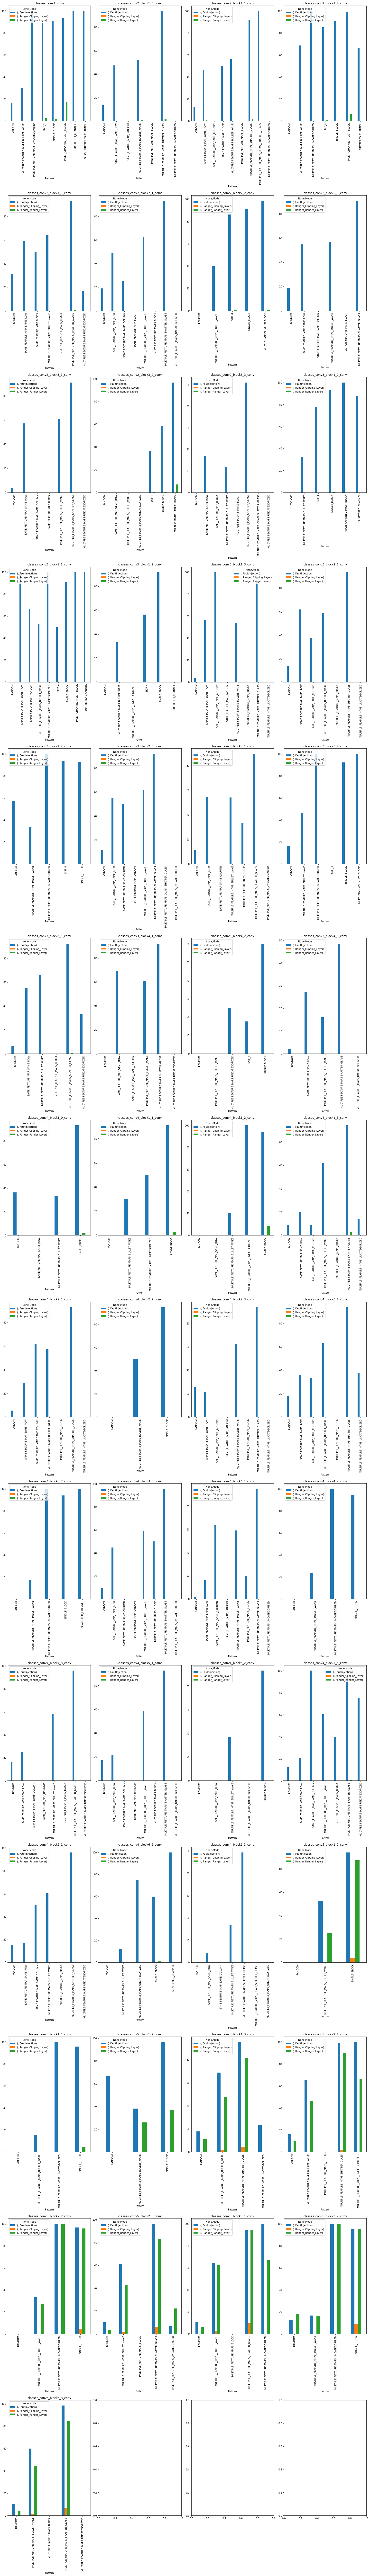

In [26]:
import math
N = len(classes_layers)
GRID_X = 4
GRID_Y = math.ceil(N/GRID_X)

fig, axs = plt.subplots( ncols=GRID_X, nrows=GRID_Y, layout='constrained', figsize=(3.5 * 6, 7.5 * GRID_Y))

for x in range(GRID_X):
    for y in range(GRID_Y):
        idx = x + y*GRID_X
        if idx < N:
            title  = classes_layers[idx]
            report = reports[idx]
            report.plot.bar(ax = axs[y,x])
            axs[y,x].set_title(title)